### В данном ноутбуке представлены результаты работы рандомизированного T-теста из раздела $2.1$ Отчета о НИР. Результаты приводятся на искусственных данных, описанных ниже.

In [22]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
import joblib

import warnings
warnings.filterwarnings('ignore')

from sklearn import linear_model
from scipy import stats
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import normalize, OrdinalEncoder, OneHotEncoder

import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)
import seaborn as sns
from tqdm.notebook import tqdm
%matplotlib inline
import numpy as np
import math
from functools import partial

In [23]:
def get_coef_significance(X, Y): 
    """
    Функция для оценки статистической значимость коэффициентов линейной регрессии

    Параметры:
        X - DataFrame - данные, содержащие несколько объектов с признаками
        Y - array - целевая метрика для объектов из X

    Выход:
        table - DataFrame - таблица со значениями p-value, относительно которых можно делать вывод о статистической значимости коэффициента при каждом признаке в X.
        lin_reg - statsmodels.OLS - обученная модель регрессии
    """ 
    X_train = sm.tools.tools.add_constant(X.values.astype(np.float64), prepend=True, has_constant='skip')
    
    Y_train = Y
    lin_reg = sm.OLS(Y_train, X_train).fit()
    summary = lin_reg.summary().tables[1]
    table = pd.read_html(summary.as_html(), header=0, index_col=0)[0]
    return table, lin_reg

In [24]:
def check_pval(pval):
    """
    Функция для автоматической проверки p-value на статистическую значимость

    Параметры:
        pval - float - значение p-value
    """  
    if pval <= 0.05:
        print(f'p-val: {pval}\nСтат. значимая разница (отвергли нулевую гипотезу о равенстве средних)')
    else:
        print(f'p-val: {pval}\nСтатзначимой разницы нет')

In [25]:
def get_n_samples(alpha, beta, eps, scale=1, alternative=2):
    """
    Функция для расчета минимального размера группы при фиксированной дисперсии, вероятности ошибок первого и второго рода и минимальной величине детектируемого эффекта.

    Параметры:
        alpha - float - вероятность ошибки первого рода
        beta - float - вероятность ошибки второго рода
        eps - float - минимальная величине детектируемого эффекта
        scale - float - соотношение в тестовой и контрольной группах
        alternative - int - односторонняя или двусторонняя альтернатива
    Выход:
        n_min - int - минимальрый размер группы
    """
    if alternative == 1:
        f_alpha = stats.norm.ppf(1 - alpha, loc=0, scale=1)
    else:
        f_alpha = stats.norm.ppf(1 - alpha / 2, loc=0, scale=1)
        
    f_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    n_min = ((f_alpha + f_beta) ** 2 * (s_c * scale + s_t)) // (scale * eps**2)
    return n_min

In [26]:
def ttest(x, y, randomized=False, alternative=2, verbose=False):
    """
    Функция для проведения T-testa в двух модификациях: с обычной и с рандомизированной T-статистикой.

    Параметры:
        x - array - значение целевой метрики в тестовой группе
        y - array - значение целевой метрики в контрольной группе
        randomized - bool - индикатор того, какой тест проводить (рандомизированный - 1, стандартный - 0)
        verbose - bool - печатать ли вспомогательную информацию
        
    Выход:
         полученное в T-тесте p-value (float)
    """ 
    n_x = x.shape[0]
    n_y = y.shape[0]
    
    s_x = np.var(x, ddof=1)
    s_y = np.var(y, ddof=1)
    dof =  (s_x / n_x + s_y / n_y) ** 2 / ((s_x / n_x) ** 2 / (n_x - 1) + (s_y / n_y) ** 2 / (n_y - 1))
    
    if randomized:
        b0 = n_x ** 0.75
        b1 = n_y ** 0.75
        
        
        theta_x = np.append(np.tile(np.array([1, np.sqrt(2), 1, np.sqrt(2)]), math.ceil(b0)),\
                   np.tile(np.array([1, np.sqrt(2), -1, -np.sqrt(2)]), n_x // 4 + 1))
        
        theta_x = theta_x[:n_x]

        theta_y = np.append(np.tile(np.array([1, np.sqrt(2), 1, np.sqrt(2)]), math.ceil(b1)),\
                   np.tile(np.array([1, np.sqrt(2), -1, -np.sqrt(2)]), n_y // 4 + 1))
        
        theta_y = theta_y[:n_y]

        t_val = (theta_x @ x - theta_y @ y) / np.sqrt(s_x * np.sum(theta_x ** 2) + s_y * np.sum(theta_y ** 2))
        
        if alternative == 1:
            p = stats.t.cdf(t_val, dof)
        else:  
            p = 2*(stats.t.cdf(-abs(t_val), dof))
        
        
    else: 
        if alternative == 1:
            t_val, p = stats.ttest_ind(x, y, equal_var=False, alternative='less')
        else:  
            t_val, p = stats.ttest_ind(x, y, equal_var=False) 
    
    if verbose:
        check_pval(p)
    return (t_val, p)

## Экспримент c фиксированным уровнем значимости $\alpha$, описанный в разделе 2.1.2 отчета о НИР

Генерируем выборку из распределения Бернулли с одинаковым средним. Проводим рандомизированный Т-тест и стандартный Т-тест, замеряем вероятность ошибки первого рода, и расстояние до предельного распределения при $H_0$ для статистики и ее квадрата. Сооветствующие распределения имеют вид $\mathcal{N}(0,1)$ и $\chi^2(1)$, соответственно.

#### Маленькая выборка

In [27]:
#вероятности успеха в серии бернулливевских испытаний для контроля и теста
p_c = 0.3 #вероятность успеха в контрольной выборке
p_t = 0.3 #вероятность успеха в тестовой выборке

alpha = 0.05 #заданная вероятность ошибки 1-го рода
beta = 0.2 #заданная вероятность ошибки 2-го рода
eps = 0.4 #величина детектируемого эффекта для величины сдвига в среднем

scale = 1.0
s_c = p_c*(1-p_c) #дисперсия элемента контрольной выборки
s_t = p_t*(1-p_t) #дисперсия элемента тестовой выборки

#рассчитываем минимально допустимые размеры тестовой и контрольной выборок
control_n = int(get_n_samples(alpha, beta, eps, scale=scale, alternative=2))
treatment_n = int(scale * control_n)
control_n, treatment_n

(20, 20)

In [28]:
#число повторений эксперимента для подсчета достигнутой вероятности ошибки 1-го рода
N_generations = 10_000

p_vals_standart = []
p_vals_random = []
p_vals_pd = []
p_vals_kl = []

t_vals_standart = []
t_vals_random = []
pd_vals = []
kl_vals = []

"""
N_generations раз повторяем T-тест с рандомизированной  и не рандомизированной статистикой, записываем итог теста
для последующего подсчета вероятностей ошибки 1-го и второго рода. 
"""
for i in tqdm(range(N_generations)):
    #генерация контрольной и тестовой выборок
    y_control = np.random.binomial(1, p_c, size=control_n)
    y_treatment = np.random.binomial(1, p_t, size=treatment_n)
    
    #рандомиизированный и нерандомизированный t-тесты
    (t_stat_orig, p_value_orig) = ttest(y_control, y_treatment, randomized = False, alternative=2)
    (t_stat_rand, p_value_rand) = ttest(y_control, y_treatment, randomized=True, alternative=2)
    
    #сохраняем значения t-статистики и p-value
    t_vals_standart.append(t_stat_orig)
    t_vals_random.append(t_stat_rand)
    
    p_vals_standart.append(p_value_orig)
    p_vals_random.append(p_value_rand)
    
# Вероятность ошибки первого рода
first_error_orig = np.mean(np.array(p_vals_standart) <= alpha)
first_error_rand = np.mean(np.array(p_vals_random) <= alpha)


# Расстояние Колмогорова между распределением T-статистики и стандартным нормальным
k_d_orig_norm = stats.ks_1samp(t_vals_standart, stats.norm.cdf).statistic
k_d_rand_norm = stats.ks_1samp(t_vals_random, stats.norm.cdf).statistic


# Расстояние Колмогорова между распределением квадрата T-статистики и Хи квадрат с 1 степенью свободы
chisquare_cdf = partial(stats.chi2.cdf, df=1)
k_d_orig_chi = stats.ks_1samp(np.array(t_vals_standart) ** 2, chisquare_cdf).statistic
k_d_rand_chi = stats.ks_1samp(np.array(t_vals_random) ** 2, chisquare_cdf).statistic

  0%|          | 0/10000 [00:00<?, ?it/s]

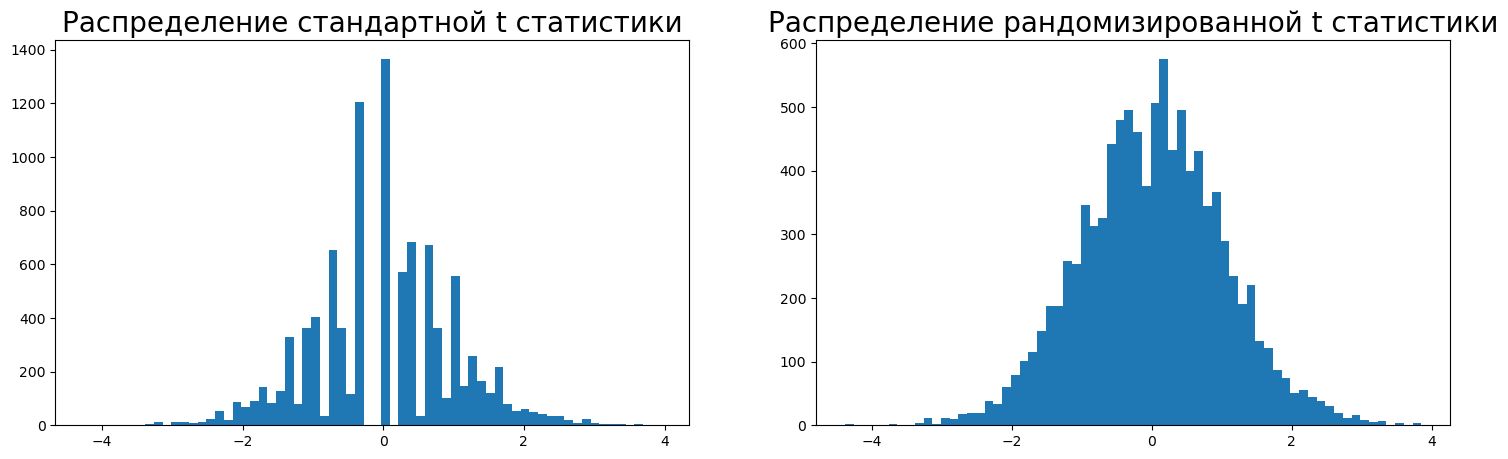

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

_ = ax1.hist(t_vals_standart, bins='auto')
ax1.set_title(f'Распределение стандартной t статистики', fontsize=20)

_ = ax2.hist(t_vals_random, bins='auto')
ax2.set_title(f'Распределение рандомизированной t статистики', fontsize=20)
plt.show()



In [32]:
#рпосто табличка с результатами
data = [[first_error_orig, k_d_orig_norm, k_d_orig_chi], [first_error_rand, k_d_rand_norm, k_d_rand_chi]]
results = pd.DataFrame(data=data, index=['original ttest', 'randomized ttest'], 
                       columns=['1 type error', 'kolmogorov dist normal',  'kolmogorov dist 𝝌^2'])
results

,1 type error,kolmogorov dist normal,kolmogorov dist 𝝌^2
original ttest,0.0538,0.0687,0.1367
randomized ttest,0.0497,0.0200,0.0399


#### Большая выборка

In [34]:
#вероятности успеха в серии бернулливевских испытаний для контроля и теста
p_c = 0.3 #вероятность успеха в контрольной выборке
p_t = 0.3 #вероятность успеха в тестовой выборке

alpha = 0.05 #заданная вероятность ошибки 1-го рода
beta = 0.2 #заданная вероятность ошибки 2-го рода
eps = 0.03 #величина детектируемого эффекта для величины сдвига в среднем

scale = 1.0
s_c = p_c*(1-p_c) #дисперсия элемента контрольной выборки
s_t = p_t*(1-p_t) #дисперсия элемента тестовой выборки

#рассчитываем минимально допустимые размеры тестовой и контрольной выборок
control_n = int(get_n_samples(alpha, beta, eps, scale=scale, alternative=2))
treatment_n = int(scale * control_n)
control_n, treatment_n


(3662, 3662)

In [35]:
#число повторений эксперимента для подсчета достигнутой вероятности ошибки 1-го рода
N_generations = 10_000

p_vals_standart = []
p_vals_random = []
p_vals_pd = []
p_vals_kl = []

t_vals_standart = []
t_vals_random = []
pd_vals = []
kl_vals = []

"""
N_generations раз повторяем T-тест с рандомизированной  и не рандомизированной статистикой, записываем итог теста
для последующего подсчета вероятностей ошибки 1-го и второго рода. 
"""
for i in tqdm(range(N_generations)):
    #генерация контрольной и тестовой выборок
    y_control = np.random.binomial(1, p_c, size=control_n)
    y_treatment = np.random.binomial(1, p_t, size=treatment_n)
    
    #рандомиизированный и нерандомизированный t-тесты
    (t_stat_orig, p_value_orig) = ttest(y_control, y_treatment, randomized = False, alternative=2)
    (t_stat_rand, p_value_rand) = ttest(y_control, y_treatment, randomized=True, alternative=2)
    
    #сохраняем значения t-статистики и p-value
    t_vals_standart.append(t_stat_orig)
    t_vals_random.append(t_stat_rand)
    
    p_vals_standart.append(p_value_orig)
    p_vals_random.append(p_value_rand)
    
# Вероятность ошибки первого рода
first_error_orig = np.mean(np.array(p_vals_standart) <= alpha)
first_error_rand = np.mean(np.array(p_vals_random) <= alpha)


# Расстояние Колмогорова между распределением T-статистики и стандартным нормальным
k_d_orig_norm = stats.ks_1samp(t_vals_standart, stats.norm.cdf).statistic
k_d_rand_norm = stats.ks_1samp(t_vals_random, stats.norm.cdf).statistic


# Расстояние Колмогорова между распределением квадрата T-статистики и Хи квадрат с 1 степенью свободы
chisquare_cdf = partial(stats.chi2.cdf, df=1)
k_d_orig_chi = stats.ks_1samp(np.array(t_vals_standart) ** 2, chisquare_cdf).statistic
k_d_rand_chi = stats.ks_1samp(np.array(t_vals_random) ** 2, chisquare_cdf).statistic

  0%|          | 0/10000 [00:00<?, ?it/s]

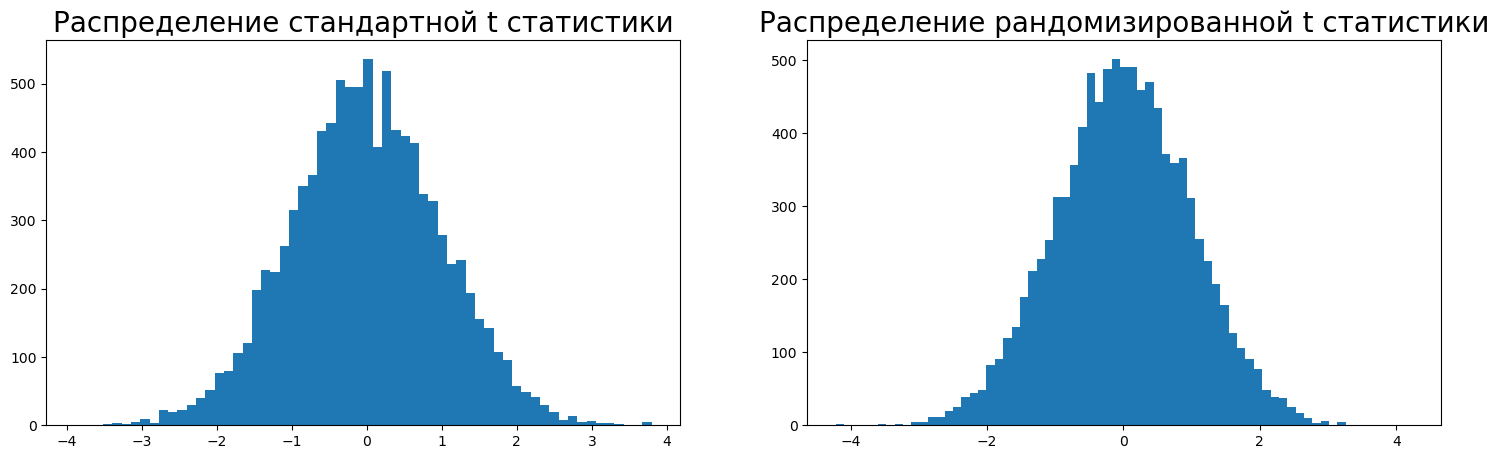

In [36]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

_ = ax1.hist(t_vals_standart, bins='auto')
ax1.set_title(f'Распределение стандартной t статистики', fontsize=20)

_ = ax2.hist(t_vals_random, bins='auto')
ax2.set_title(f'Распределение рандомизированной t статистики', fontsize=20)
plt.show()

